# Genomic Models of Skipped Exon Events using Convolutional Neural Models

In [4]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, BatchNormalization
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)
from keras_pooling import KMaxPooling

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

In [2]:
num_filters = [100,64,32]
filter_length = [10,4,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu', input_dim=4))
model1.add(keras_pooling.KMaxPooling(pooling_size=5))
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [5]:
data = cPickle.load(open('../data/se_data.pkl'))

In [7]:
data[0:5]

[(u'SE:20:49557470-49557642:49557746-49558568:-',
  'TTGTAGTGATGGAGTTTTGCCATGTTGCCCAGGCTGGTCACTCCTGGGCTCAAGTGATCCAGCCATCTTGGCCTCCTGGGATTACAGGTGTGAGCCACCGCGCCTAGCCAGGTCTCC',
  0.09861069523430001),
 (u'SE:20:49557470-49557666:49557746-49558568:-',
  'TTGTAGTGATGGAGTTTTGCCATGTTGCCCAGGCTGGTCACTCCTGGGCTCAAGTGATCCAGCCATCTTGGCCTCCTGGGATTACAGGTGTGA',
  0.00951384627408),
 (u'SE:20:49557492-49557642:49557746-49558568:-',
  'TTGTAGTGATGGAGTTTTGCCATGTTGCCCAGGCTGGTCACTCCTGGGCTCAAGTGATCCAGCCATCTTGGCCTCCTGGGATTACAGGTGTGAGCCACCGCGCCTAGCCAGGTCTCC',
  0.23432211001999997),
 (u'SE:20:49557746-49558568:49558663-49562274:-',
  'CTACAGGAAGCAAAAGGAGGGTAATTTTGATATTGTCTCTGGAACTCGCTACAAAGGAAATGGAGGTGTATATGGCTGGGATTTGAAAAGAAAAATAATCAGGTAGGT',
  0.582630391294),
 (u'SE:1:169824105-169824937:169825098-169828182:-',
  'CTTCAGATTCTCCTATGTGTGTCGTCTGCAGCCATCACAGTCAGATCTCGCCAATCTTGGAGAACCCCTTCTCTAGCATATTCCCTAAATGTTTCTTTTCTGGCAGCACGCCCATCAACAGCAAGAAGCACATACAGCGAGATTACTACAATACTCTTTTACAGACAGGTAGAA',
  0.669221437921)]

In [10]:
genomic_exons = [c[1] for c in data]
genomic_exons_encoded = [nn_utils.seq_to_array(s) for s in genomic_exons]
actual = [c[2] for c in data]
new_actual = []
new_g = []
max_len = 200
min_len = 25
for a, g in zip(actual, genomic_exons_encoded):
    if a!=None and a>0.1 and a<0.9 and len(g)<=max_len and len(g) >= min_len:
        new_actual.append(a)
        new_g.append(g)

In [11]:
new_g2 = map(lambda x: np.rollaxis(sequence.pad_sequences(np.rollaxis(x, 1), max_len), 1), new_g)
new_g2 = np.dstack(new_g2)

In [12]:
new_g2 = np.rollaxis(new_g2, 2)

In [13]:
G_train, G_test, P_train, P_test = train_test_split(new_g2, new_actual, test_size=0.2, random_state=0)

In [14]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(G_train, P_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(G_test, P_test),
          callbacks=[early_stopping])

Train on 9116 samples, validate on 2280 samples
Epoch 1/50
9116/9116 [==============================] - 666s - loss: 0.6933 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 1.0000
Epoch 2/50
9116/9116 [==============================] - 617s - loss: 0.6932 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 1.0000
Epoch 3/50
9116/9116 [==============================] - 618s - loss: 0.6929 - acc: 1.0000 - val_loss: 0.6931 - val_acc: 1.0000
Epoch 4/50
9116/9116 [==============================] - 614s - loss: 0.6925 - acc: 1.0000 - val_loss: 0.6929 - val_acc: 1.0000
Epoch 5/50
9116/9116 [==============================] - 663s - loss: 0.6925 - acc: 1.0000 - val_loss: 0.6929 - val_acc: 1.0000
Epoch 6/50
1000/9116 [==>...........................] - ETA: 520s - loss: 0.6925 - acc: 1.0000

KeyboardInterrupt: 

In [16]:
X_a3_train, X_a3_test, Y_a3_train, Y_a3_test = nn_utils.load_a3_data()
# position 235 corresponds to splice site 1?
Y2_a3_test = Y_a3_test[:,235]
Y2_a3_train = Y_a3_train[:,235]
X1_a3_train = X_a3_train.map(lambda x: x[25:])
X1_a3_test = X_a3_test.map(lambda x: x[25:])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_a3_train = np.dstack(X1_a3_train)
X1_a3_train = np.rollaxis(X1_a3_train, 2)
X1_a3_test = np.dstack(X1_a3_test)
X1_a3_test = np.rollaxis(X1_a3_test, 2)

Y2_a3_train = Y2_a3_train.reshape((len(Y2_a3_train), 1))
Y2_a3_test = Y2_a3_test.reshape((len(Y2_a3_test), 1))

In [17]:
model2 = Sequential()
model2.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model2.add(Dropout(0.25))
model2.add(Convolution1D(num_filters[1], filter_length[1], activation='relu', input_dim=4))
model2.add(keras_pooling.KMaxPooling(pooling_size=5))
model2.add(Flatten())
model2.add(Dense(output_dim=1, activation='linear'))
model2.add(Activation('sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam')

In [18]:
model2.fit(X1_a3_train, Y2_a3_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_a3_test, Y2_a3_test),
          callbacks=[early_stopping])

Train on 66240 samples, validate on 16560 samples
Epoch 1/50
66240/66240 [==============================] - 400s - loss: 0.1023 - acc: 1.0000 - val_loss: 0.0647 - val_acc: 1.0000
Epoch 2/50
66240/66240 [==============================] - 397s - loss: 0.0685 - acc: 1.0000 - val_loss: 0.0639 - val_acc: 1.0000
Epoch 3/50
66240/66240 [==============================] - 375s - loss: 0.0679 - acc: 1.0000 - val_loss: 0.0634 - val_acc: 1.0000
Epoch 4/50
66240/66240 [==============================] - 373s - loss: 0.0671 - acc: 1.0000 - val_loss: 0.0625 - val_acc: 1.0000
Epoch 5/50
66240/66240 [==============================] - 372s - loss: 0.0660 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 1.0000
Epoch 6/50
66240/66240 [==============================] - 372s - loss: 0.0650 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 1.0000
Epoch 7/50
66240/66240 [==============================] - 372s - loss: 0.0643 - acc: 1.0000 - val_loss: 0.0611 - val_acc: 1.0000
Epoch 8/50
66240/66240 [=======================

In [20]:
predictions2 = model2.predict(X1_a3_test)

In [21]:
r2_score(predictions2, Y2_a3_test)

-4.6262370481693154

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


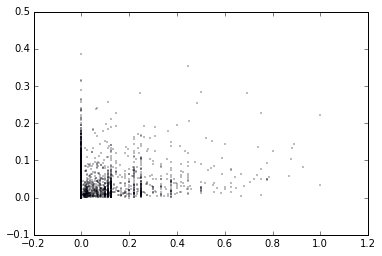

In [22]:
plt.scatter(Y2_a3_test, predictions2, s=0.1)
plt.show()

In [23]:
model2.save_weights('../data/kmax-a3.h5')
model_json = model2.to_json()
with open('../data/kmax-a3-model.json', 'w') as f:
    f.write(model_json)


## Testing a combination of a5 and a3 models

In [7]:
model1 = model_from_json(open('../data/convolutional-kmax-model.json').read(), custom_objects={'KMaxPooling': KMaxPooling})

In [8]:
model1.load_weights('../data/convolutional-kmax.h5')

In [9]:
model2 = model_from_json(open('../data/kmax-a3-model.json').read(), custom_objects={'KMaxPooling': KMaxPooling})

In [10]:
model2.load_weights('../data/kmax-a3.h5')

In [14]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

get_3rd_layer_output_2 = K.function([model2.layers[0].input],
                                  [model2.layers[-2].get_output(train=False)])
get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    #return get_3rd_layer_output_1([input_data])[0]
    return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [12]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [15]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [16]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

In [17]:
r2_score(hal_pred, model_pred)

-0.028693055375551557

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


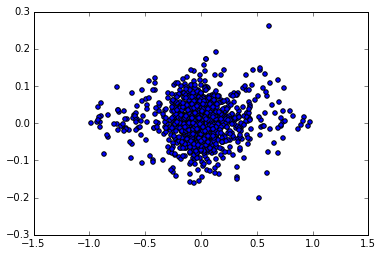

In [18]:
plt.scatter(hal_pred, model_pred)

In [53]:
score_mut = hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HETERO_DPSI_PRED, model_dpsi_pred, table1.HETERO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

In [54]:
float(sum(pos_or_neg))/float(len(pos_or_neg))

0.46600741656365885

In [122]:
r2_score(hal_pred_2, model_pred_2)

-0.13659522344523523

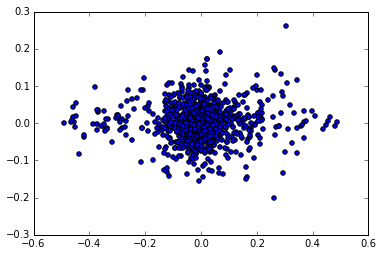

In [124]:
plt.scatter(hal_pred_2, model_pred_2)

In [109]:
r2_score(model_pred_2[:20], actual[:20])

-4.4401482990026802

In [24]:
table1.head()

id                                              EVENT  HETERO_COUNTS  \
0  11  chr10:102286311:102285953|102286156:-@chr10:10...              1   
1  12  chr10:102286311:102285953|102286156:-@chr10:10...              5   
2  17  chr10:102289263:102289123|102289137:-@chr10:10...              1   
3  20  chr10:102746732:102746444|102746506:-@chr10:10...            132   
4  26  chr10:102750193:102750300|102750420:+@chr10:10...              1   

   HETERO_PSI  HOMO_COUNTS  HOMO_PSI  \
0    0.020000            0       NaN   
1    0.022000            0       NaN   
2    0.040000            0       NaN   
3    0.884621           30  0.737667   
4    0.110000            0       NaN   

                                             MUT_SEQ  SD_DIST       SNP_ID  \
0  TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGA...      203  rs182281336   
1  TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGA...      203  rs116226794   
2  GCCCCTGCGACTTGAAGCCTTCGGAGCGGCTGGAGAGCGGGCTCGC...       14  rs145628277   
3  ATCCACTGCAAGTCGGTCGAGGAGATCTCGACGCTGGTGCAGAAGC...       62    rs2863095   
4  GGAGGCAGCCAAGAGAGTTTTCAGGATGCTAGTTCTTCTGCCTGGG...      120  rs147513679   

   SNP_POS        ...          MUT_EFFECT_SIZE  MAXENT_EFFECT_SIZE HOMO_PRED  \
0      386        ...                -0.853681                0.00  0.010493   
1      211        ...                 0.059698                0.00  0.025752   
2      208        ...                 0.416883                0.00  0.082848   
3      203        ...                -3.893001               -4.26  0.257667   
4      303        ...                 0.392244                0.00  0.111095   

  HETERO_PRED HETERO_DPSI HOMO_DPSI HETERO_DPSI_PRED HOMO_DPSI_PRED  \
0    0.017394   -0.004296       NaN        -0.006902      -0.013803   
1    0.025024   -0.002296       NaN         0.000728       0.001456   
2    0.069520   -0.016192       NaN         0.013328       0.026656   
3    0.601099   -0.059910 -0.206865        -0.343432      -0.686865   
4    0.094475    0.032145       NaN         0.016620       0.033240   

   LARGE_HETERO_EFFECT  LARGE_HOMO_EFFECT  
0                False              False  
1                False              False  
2                False              False  
3                 True               True  
4                False              False  

[5 rows x 28 columns]

In [25]:
table1.MUT_SEQ[0]

'TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGATGCACTGGCACCTAGACATGTACAACAGGAACCGTGTGGATACATCCCCCACACCTGTTTCTTGGCATGTCATGTGTATGCAGCTCTTCGGTTTCCTGGCTTTCATGATATTCATGTGCTGGGTGGGGGACGTGTACCCTGTCTACCAGCCTGTGGTGAGTATCCGAGAAGTGCTCCCTTAGGCACGCTTGCTTAGCCCCATTTCCTGAGGGAGTGAAGTCTCTGGGGTAGGAATCCAGTCAATACCAAGCTTGGCTTCCTGGAGTCTTAGGAGATAGGAAGATAGGAGGGCCTTGACCCATTGGCCTGCCACAAGTACCACAGCACTTCTCCACCCCTATTTCTTGGACCAGTCTGGGTGAGTAGATACACTTGAAGACTAGATGAGCAATGAGTGTGTGGAAACCAGCTAGTCACCAGAGTTGCCATTTGGGGATTATATTTATTAACAATATTTCATTAAGTGATCTTTCACAGTAGAGTTAAGGAATCTTGAGTGAAAATCTTATCCTTTGTTGGACTTGTGAAGGGCACGTCCTGTAGTATATTGGAAGCAAT'

In [26]:
table1.WT_SEQ[0]

'TGCAGGAAGAGTAGTATGTGACAGCTATTTGTCTTTCTGCCTCAGATGCACTGGCACCTAGACATGTACAACAGGAACCGTGTGGATACATCCCCCACACCTGTTTCTTGGCATGTCATGTGTATGCAGCTCTTCGGTTTCCTGGCTTTCATGATATTCATGTGCTGGGTGGGGGACGTGTACCCTGTCTACCAGCCTGTGGTGAGTATCCGAGAAGTGCTCCCTTAGGCACGCTTGCTTAGCCCCATTTCCTGAGGGAGTGAAGTCTCTGGGGTAGGAATCCAGTCAATACCAAGCTTGGCTTCCTGGAGTCTTAGGAGATAGGAAGATAGGAGGGCCTTGACCCATTGGCCTGCCACAAGTACCACAGCACTTCTCCACCCCTACTTCTTGGACCAGTCTGGGTGAGTAGATACACTTGAAGACTAGATGAGCAATGAGTGTGTGGAAACCAGCTAGTCACCAGAGTTGCCATTTGGGGATTATATTTATTAACAATATTTCATTAAGTGATCTTTCACAGTAGAGTTAAGGAATCTTGAGTGAAAATCTTATCCTTTGTTGGACTTGTGAAGGGCACGTCCTGTAGTATATTGGAAGCAAT'

In [39]:
lens = [len(x) for x in table1.WT_SEQ]

In [46]:
get_score(wt_seqs_encoded[0])

array([[-5.20796633]], dtype=float32)

In [47]:
get_score(mut_seqs_encoded[0])

array([[-5.37070274]], dtype=float32)

In [49]:
get_score(wt_seqs_encoded[2])

array([[-4.73700047]], dtype=float32)

In [50]:
get_score(mut_seqs_encoded[2])

array([[-4.71270084]], dtype=float32)

In [51]:
table1.HETERO_DPSI[0]

-0.0042961165000000006

In [52]:
table1.HETERO_DPSI[2]

-0.016192307699999998

In [58]:
table1.WT_PSI[2]

0.056192307699999992

In [59]:
get_delta_psi(wt_seqs_encoded[0], mut_seqs_encoded[0], table1.WT_PSI[0])

array([[-0.00357329]], dtype=float32)

In [121]:
i = 24
print get_delta_psi(wt_seqs_encoded[i], mut_seqs_encoded[i], table1.WT_PSI[i])[0][0]
print table1.HETERO_DPSI[i]
print table1.HETERO_DPSI_PRED[i]

0.0130038
0.0712765957
0.0660538237


In [64]:
table1.HETERO_DPSI[3]

-0.059910037899999997